In [2]:
%load_ext autoreload
import sys
sys.path.append('../../..')
import numpy as np
from scipy.interpolate import interp1d, interp2d

import config
import main_components as main
import pickle
import darkhistory.physics as phys
from darkhistory.spec.spectra import Spectra
from darkhistory.spec.spectrum import Spectrum
from plotting_utils import plot_distortion, download_plot

import matplotlib
matplotlib.rc_file('../../../matplotlibrc')
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as colors
%matplotlib inline

output_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/output/'
fig_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/figs/'

# Generate data, if not loading previous

In [3]:
# CMB constraints on interaction rates
input_dir = config.data_path

f_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_swave.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1]

f_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_swave.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1]

f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))

f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)

decay_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

#Derived from Planck 2018 cosmological parameters
p_ann = 3.5e-28

def param_bound_elec_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_elec_CMB(mDM*1e-9)])[0]

def param_bound_phot_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_phot_CMB(mDM*1e-9)])[0]
    
def param_bound(mDM, DM_process, pri):
    if pri == 'elec':
        return param_bound_elec_CMB(mDM, DM_process)
    else:
        return param_bound_phot_CMB(mDM, DM_process)

In [76]:
%autoreload

pri = 'elec'
DM_process = 'swave'
mDM = 2e8
param = param_bound(mDM, DM_process, pri)

nmax = 10
start_rs, end_rs = 3000, 4
cf = 16
rtol = 1e-6

no_boost = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param,
    sigmav=param,
    primary=pri+'_delta',
#     struct_boost=phys.struct_boost_func(),
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=cf, rtol=rtol,
    distort=True, recfast_TLA=True,
    fexc_switch = False, 
    reprocess_distortion=False, 
    nmax=nmax,
    reion_switch=False
)

boost = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param,
    sigmav=param,
    primary=pri+'_delta',
    struct_boost=phys.struct_boost_func(),
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=cf, rtol=rtol,
    distort=True, recfast_TLA=True,
    fexc_switch = False, 
    reprocess_distortion=False, 
    nmax=nmax,
    reion_switch=False
)

../../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../../../darkhistory/low_energy/atomic.py:687: RuntimeWarning: overflow encountered in true_divide
  K[nl, states_l == l+1] = BB['dn'][l+2:, n, l+1]/tot_rate


# Plot

In [77]:
ICS_component = boost['lowengphot'].copy()
ICS_component._grid_vals *= list(map(int, ICS_component.eng < phys.rydberg))
ICS_component.redshift(1)
ICS_component = {'distortion': ICS_component.sum_specs()}

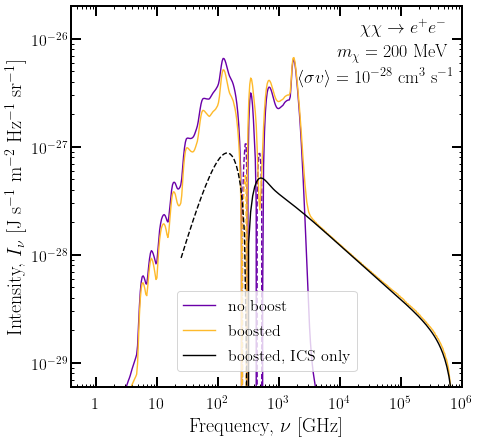

In [93]:
cmap = cm.plasma(np.linspace(0.2,0.85,2))

plt.figure(figsize=(7,7))
ax = plt.gca()

plot_distortion(ax, no_boost, label=r'no boost',
                color=cmap[0], leg=True, first=False)
plot_distortion(ax, boost, label=r'boosted',
                color=cmap[1], leg=True, first=False)
plot_distortion(ax, ICS_component, label=r'boosted, ICS only',
                color='k', leg=True, first=False)
#plt.ylim(1e-30,1e-22)
plt.text(0.74, 0.93, r'$\chi\chi \rightarrow e^+ e^-$', fontsize=18, transform = ax.transAxes)
plt.text(0.68, 0.86, r'$m_\chi = 200$ MeV', fontsize=18, transform = ax.transAxes)
plt.text(0.58, 0.8, r'$\langle \sigma v \rangle = 10^{-28}$ cm$^3$ s$^{-1}$', fontsize=18, transform = ax.transAxes)

plt.legend(loc='lower center')
plt.savefig(fig_dir+'structure_boost.pdf')
plt.show()